**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution. Please read all the instructions in each notebook carefully.**  

# Exercise 1

## Part 3. Implement and train a multilayer perceptron (MLP) using PyTorch

In the final part of this assignment, you will implement and train a **Multilayer Perceptron (MLP)** for a regression problem using PyTorch.

### Objective

This assignment aims to help you understand the basic concepts and operations involved in building and training neural networks on PyTorch.

You will follow the steps below:
1. Data Generation: Construction of synthetic dataset for training. No implementation is required for this step, the function is provided.
2. MLP Model Construction: Defining MLP architecture with given parameters and implementing forward pass in PyTorch.
3. Training the Network: Implementating the training loop including loss calculation, backpropagation, and parameter updates using PyTorch's built-in methods.

If you are new to PyTorch, you can review the following [introductory materials](https://pytorch.org/tutorials/beginner/basics/intro.html) to get familiar with it.

In [ ]:
# Do not delete this cell

### Import the necessary libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

### 1. Data Generation

In this task, we will work with **2D data** where each data point has two features. While this is a basic example, real-world deep learning applications often deal with higher-dimensional data.

We will generate synthetic data based on $y = x_1^2 +  x_2^2 + \text{noise}$. The added `noise` is used to simulate randomness in the data.

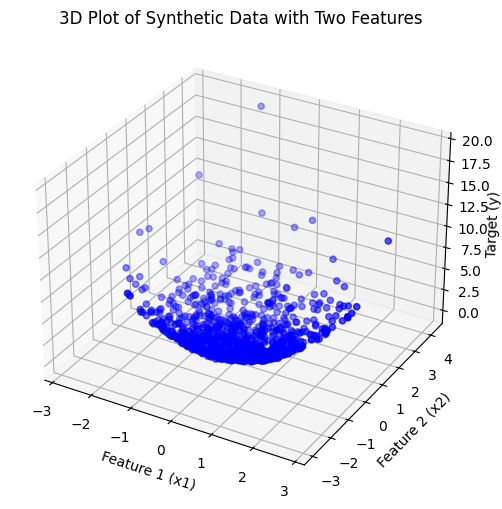

Shape of the input  x: (1000, 2)
Shape of the target y: (1000, 1)


In [2]:
def generate_data_2d(num_samples=1000):
    # Generate random input data with shape (num_samples, 2)
    np.random.seed(4)
    x = np.random.randn(num_samples, 2)
    noise = np.random.randn(num_samples, 1) * 0.1  # Add small noise

    # Compute the output with the defined pattern
    y = np.sum(x**2, axis=1, keepdims=True) + noise

    x = torch.FloatTensor(x)
    y = torch.FloatTensor(y)

    return x, y

def display_data(x,y):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:, 0].numpy(), x[:, 1].numpy(), y[:,0].numpy(), c='b', marker='o')

    ax.set_xlabel('Feature 1 (x1)')
    ax.set_ylabel('Feature 2 (x2)')
    ax.set_zlabel('Target (y)', labelpad=0)
    ax.set_title('3D Plot of Synthetic Data with Two Features')

    plt.show()

x, y = generate_data_2d(1000)
display_data(x,y)

print(f'Shape of the input  x: {x.numpy().shape}')
print(f'Shape of the target y: {y.numpy().shape}')

### 2. MLP Model for Regression

In this step, you will define a Multilayer Perceptron (MLP) model. You are provided with a template for the model class. Observe that the model inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which is the base class for all the neural networks in PyTorch. The backward pass is handled automatically by PyTorch. Commonly, there is no need to define the backward pass unless you need to customize the gradient flow.

##### Steps to follow:
1. Initialize the layers: You will define the layers using [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html). The model architecture should have the following structure:
    -  Input layer: Takes 2 features.
    -  Three hidden layers with 12, 10, and 6 units, respectively. Each layer is followed by a ReLU activation.
    -  Output layer: Produces a single output.
2. Forward pass: Implement the `forward()` method to define the data flow in the model.



##### Hints:
- You can simplify the model definition by using [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). It allows you to group the layers and activation into a sequence.


In [10]:
class MLP(nn.Module):
    def __init__(self, in_features=2, hidden_size1=12, hidden_size2=10, hidden_size3=6, out_features=1):
        super(MLP, self).__init__()
        self.in_features = in_features
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.out_features = out_features

        self.layers = nn.Sequential(
            nn.Linear(in_features, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, out_features)
        )


    def forward(self, x):
      return self.layers(x)

In [9]:
feedback_txt = []

# This cell checks the number of layers
def test_layers():

    all_tests_successful = True
    model = MLP()
    relu_count, linear_count = 0, 0
    for layer in model.modules():
        if isinstance(layer, nn.ReLU):
            relu_count += 1
        if isinstance(layer, nn.Linear):
            linear_count += 1

    if relu_count == 0:
        all_tests_successful = False
        msg = "At least one ReLU layer is expected, but got 0."
        feedback_txt.append(f"Visible test: {msg}")
        raise AssertionError(msg)

    if linear_count != 4:
        all_tests_successful = False
        msg = f"Expected 4 fully connected (Linear) layers, but got {linear_count}."
        feedback_txt.append(f"Visible test: {msg}")
        raise AssertionError(msg)

    if all_tests_successful:
        print("\033[92mVisible test for layer count passed successfully!\033[0m")

test_layers()

Visible test for layer count passed successfully!


In [ ]:
# This cell contains hidden test cases that will be evaluated after submission

### 3. Train the MLP network

In this section, you will implement the training loop for the Multilayer Perceptron.

Before diving into the training loop, let us define helper functions that we will use to simplify the workflow and visualize the training mechanism.

In [8]:
def init_model(learning_rate=0.05):
    """
    Initializes the model, loss function, and optimizer.

    Args:
    - learning_rate (float): Learning rate.

    Returns:
    - model (MLP): An instance of the MLP model.
    - criterion (nn.MSELoss): Mean squared error loss function for regression.
    - optimizer (torch.optim.Adam): Adam optimizer for updating model weights.

    Usage:
    Call this function before the training starts.
    """
    model = MLP()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

# Function to visualize the loss curve after training
def plot_loss_curve(losses, epochs):
    """
    Plots the training loss over epochs after the training loop.

    Args:
    - losses (list): List of loss values for each epoch.
    - epochs (int): Total number of epochs.

    Usage:
    After the training is completed, call this function to visualize how the training loss has changed over time.
    """
    fig, ax = plt.subplots()
    ax.plot(range(1, epochs + 1), losses, 'b', label='Training Loss')
    ax.grid(True)
    ax.set_title('Training Loss Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.legend()
    plt.show()

The model, loss function, and optimizer are instantiated (`init_model`) outside of the training loop. You will now implement the training loop.

##### Steps to follow for each iteration (epoch):

1. Set all gradients to zero: Use optimizer's `zero_grad()` method  to prevent gradient accumulation from previous iterations.
2. Perform the forward pass: Pass the input through the model (you do not have to explicitly call the `forward()` method as PyTorch already handles this.)
3. Compute the loss (see [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)).
4. Backpropagate **the loss** (see [backward](https://pytorch.org/docs/stable/generated/torch.autograd.backward.html)).
5. Update the parameters: Use the optimizer's `step()` method.
6. Store the **numerical** loss values after each iteration to visualize the loss curve at the end of the training.
  
##### Recommended parameters:
1. You **must** use Mean Squared Error (MSE) as the loss function (see [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)) and the Adam optimizer (see [optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)).
2. A recommended learning rate is 0.05.
3. Set the number of epochs to at least 100 for the model to converge.


##### Important notes:
- For simplicity, use all the training data to compute the gradients in each iteration (this is called full-batch training).
- Try running your model without calling zero_grad() and **observe the effect of gradient accumulation** on the loss curve.
- When storing the loss values ensure that you save the numerical value, not the tensor itself.
- You can experiment with the model parameters (such as learning rate and the number of epochs) but you must use the provided x and y values as the data.

In [11]:
def train_mlp(model, criterion, optimizer, x, y, epochs=200):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses  # Return to visualize the learning curve

In [12]:
# This cell tests the training code
from unittest.mock import patch
def test_train_calls():
    all_tests_successful = True
    model, criterion, optimizer = init_model(0.05)
    with patch('torch.Tensor.backward') as mock_backward, patch.object(optimizer, 'step') as mock_step:
        train_mlp(model, criterion, optimizer, x, y, epochs=10)
        if not mock_backward.called:
            all_tests_successful = False
            msg = "You forgot to calculate the gradients."
            feedback_txt.append(f"Visible test: {msg}")
            raise AssertionError(msg)
        if not mock_step.called:
            all_tests_successful = False
            msg = "Visible test: You forgot to update the weights."
            feedback_txt.append(f"Visible test: {msg}")
            raise AssertionError(msg)

        if all_tests_successful:
            print("\033[92mVisible test passed.\033[0m")
test_train_calls()

Visible test passed.


In [13]:
x, y = generate_data_2d(1000) # DO NOT OVERWRITE THIS

In [14]:
# Using recommended parameters to train the model (you can modify these as desired)
# You are not expected to implement anything
# To continue using the default parameters, remove raise NotImplementedError()
num_epochs = 200
learning_rate = 0.05

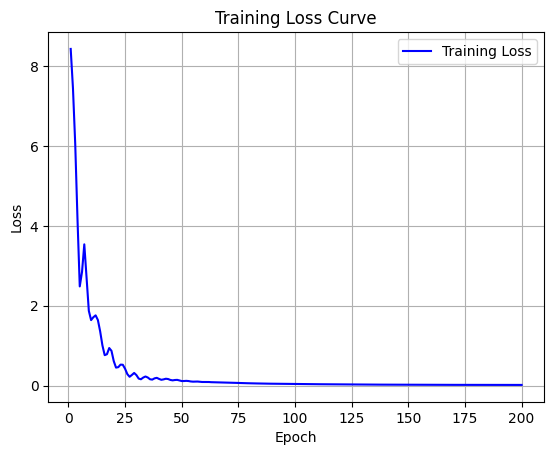

In [15]:
# Initialize the model, criterion, and optimizer
model, criterion, optimizer = init_model(learning_rate)
losses = train_mlp(model, criterion, optimizer, x, y, epochs=num_epochs)
plot_loss_curve(losses, len(losses))

In [16]:
# Test cell
# Ensure your model achieves a low loss and the plot matches expected outputs.
final_loss = losses[-1]
try:
    assert final_loss < 0.25, f'Loss is too high, got {final_loss}, check your implementation.'
except AssertionError as e:
    feedback_txt.append(f'Visible test, Loss is too high, got {final_loss}, check your implementation.')
    raise

In [17]:
# This cell contains hidden test cases that will be evaluated after submission

In [18]:
# Do not delete this cell